# Denoising example with a 2d image

In this notebook we show how to apply Clear-Skies to 2d image denoising. It simlates an observed noisey image and then applies constrained BPDN with a redundent dictionary to estimate the true signal.

In [78]:
import sys
#put path of Clear-Skies folder repository
sys.path.insert(0,'../../Clear-Skies')
#put path of Optimus Primal folder repository
sys.path.insert(0,'../../Optimus-Primal')
import numpy as np
from clearskies import solver
from clearskies import map_uncertainty
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [79]:
def open_fits(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].data
def open_header(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].header

Here we load the ground truth image

In [80]:
input_file = "../data/lmc.fits"

x_true = open_fits(input_file)
header = open_header(input_file)

Here we choose the noise level in db and add the noise

Text(0.5, 1.0, 'Observed Image')

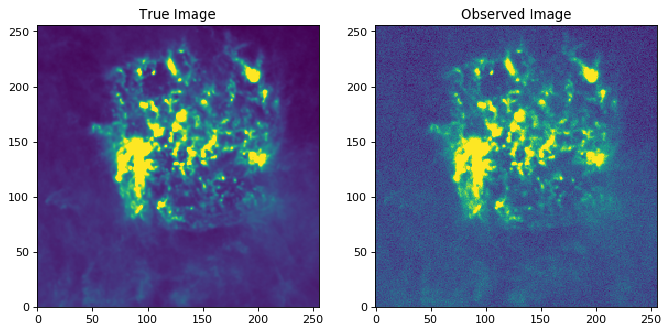

In [81]:
ISNR = 20. #in db (relative to the input signal)
sigma = 10**(-ISNR/20.) * np.sqrt(np.sum(np.abs(x_true)**2)/(x_true.shape[0] * x_true.shape[1]))
width, height = x_true.shape 

W = np.ones(x_true.shape)

y = W * x_true + np.random.normal(0, sigma, x_true.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), dpi=80, sharey=False, sharex=True)
ax[0].imshow(x_true, vmax=np.max(x_true) * 0.1,origin='lower')
ax[0].set_title("True Image")
ax[1].imshow(y, vmax=np.max(x_true) * 0.1,origin='lower')
ax[1].set_title("Observed Image")

Below we choose the dictionary that we expect to represent our signal. Dirac is good for point sources, wavelets are good for extended and smooth signals on different scales. More levels is good for extended sources because the largest level probes the largest scales. We normally require that image width > $2^{\rm levels - 1}$. Typically a redundent dictionary works well for many complex images.

In [82]:
wav = ["db1", "db2", "db3", "db4","db5", "db6", "db7", "db8"]
#wav = ["db8"]
#wav = ["dirac"]
levels = 4

Here we choose the options for our algorithm, how iterations, real + positivity constraints, tollerance for convergence.

In [83]:
options = {'tol': 1e-3, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': True, 'real': True}
beta = 1e-3

Next we run the solver for our solution image $\mathbf{z}$ to the minimum of
$$ \|\mathbf{\Psi} \mathbf{x} \|_{\ell_1}\quad {\rm such\, that}\quad \|\mathbf{W} \mathbf{x} - \mathbf{y} \|_{\ell_2} \leq \epsilon $$
where $\epsilon = \sigma_{\rm noise}\sqrt{N - 2\sqrt{2N}}$. $\mathbf{\Psi}$ is the wavelet dictionary transform and $\mathbf{W}$ is the noise weights. $\|\mathbf{\alpha} \|_{\ell_1} = \sum_k |\alpha_k|$ and $\|\mathbf{\alpha} \|_{\ell_2} = \sqrt{\sum_k |\alpha_k|^2}$.

The basic idea is that $\mathbf{z}$  will not overfit to the signal because it can be efficiently represented with the dictionary.

In [92]:
z, diag = solver.solver(solver.algorithm.l1_constrained, y, sigma, W, wav, levels, beta, options)

2020-05-13 19:50:39,096 - Clear Skies - INFO - Using wavelets ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8'] with 4 levels
2020-05-13 19:50:39,103 - Clear Skies - INFO - Using an estimated noise level of 0.8525821286015454 (weighted image units, i.e. Jy/Beam)
2020-05-13 19:50:39,175 - Clear Skies - INFO - Denosing using constrained l1 regularization
2020-05-13 19:50:39,250 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-05-13 19:50:39,343 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.333336
2020-05-13 19:50:43,365 - Optimus Primal - INFO - [Primal Dual] converged in 36 iterations


We print the input and output SNR, and compare the true, recovered, observed, and residual maps.

Input SNR =  20.0
Recovered SNR =  25.69617518656535


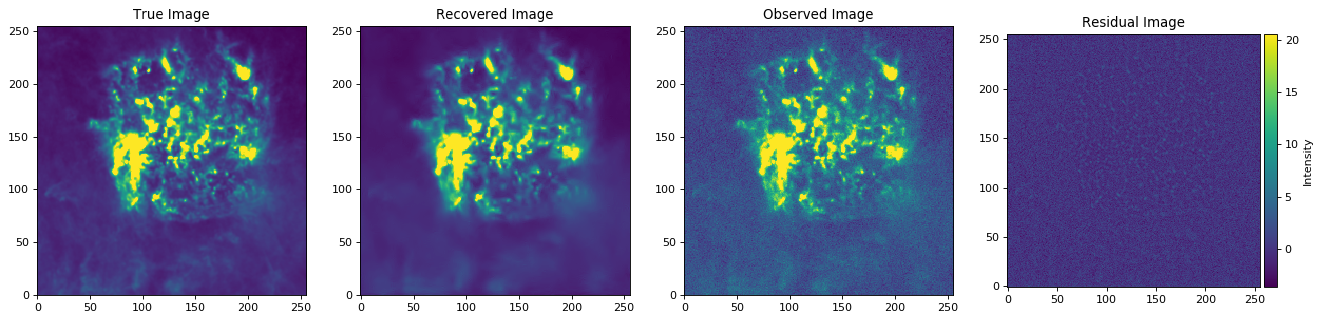

In [93]:
SNR = np.log10(np.sqrt(np.sum(np.abs(x_true)**2))/np.sqrt(np.sum(np.abs(x_true - z)**2))) * 20.
print("Input SNR = ", ISNR)
print("Recovered SNR = ", SNR)
max_val = np.max(x_true) * 0.1
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 7), dpi=80, sharey=False, sharex=True)
ax[0].imshow(x_true, vmax=max_val,origin='lower')
ax[0].set_title("True Image")
ax[1].imshow(np.real(z), vmax=max_val,origin='lower')
ax[1].set_title("Recovered Image")
ax[2].imshow(np.real(y), vmax=max_val,origin='lower')
ax[2].set_title("Observed Image")
ax[3].set_title("Residual Image")
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(ax[3].imshow(np.real(y - z), vmax=max_val,origin='lower'), cax=cax, orientation='vertical',label="Intensity");


We now do the same for the gradient map of the signal

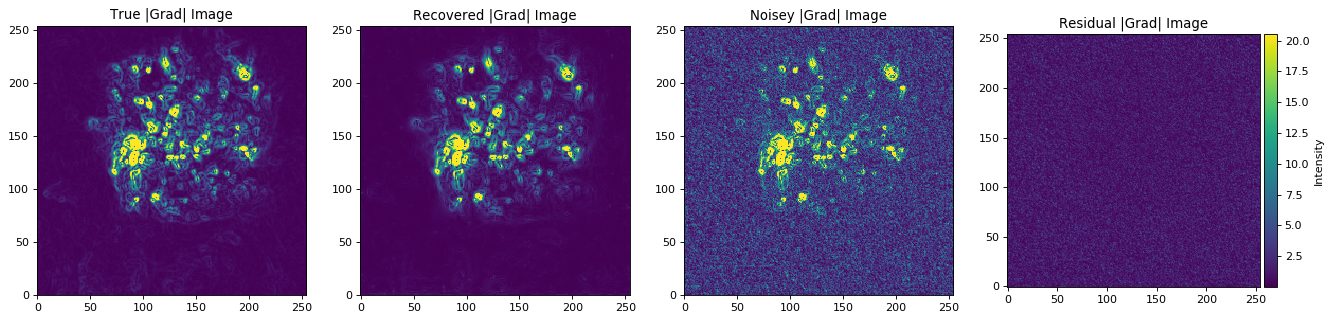

In [94]:
max_val = np.max(np.sqrt((np.diff(np.real(x_true[:,:-1]),axis=0)**2 + np.diff(np.real(x_true[:-1,:]),axis=1)**2))) * 0.1
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 7), dpi=80, sharey=False, sharex=True)
ax[0].imshow(np.sqrt((np.diff(np.real(x_true[:,:-1]),axis=0)**2 + np.diff(np.real(x_true[:-1,:]),axis=1)**2)), vmax=max_val,origin='lower')
ax[0].set_title("True |Grad| Image")
ax[1].imshow(np.sqrt((np.diff(np.real(z[:,:-1]),axis=0)**2 + np.diff(np.real(z[:-1,:]),axis=1)**2)), vmax=max_val,origin='lower')
ax[1].set_title("Recovered |Grad| Image")
ax[2].imshow(np.sqrt((np.diff(np.real(y[:,:-1]),axis=0)**2 + np.diff(np.real(y[:-1,:]),axis=1)**2)), vmax=max_val,origin='lower')
ax[2].set_title("Noisey |Grad| Image")
ax[3].set_title("Residual |Grad| Image")
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(ax[3].imshow(np.sqrt((np.diff(np.real((y - z)[:,:-1]),axis=0)**2 + np.diff(np.real((y - z)[:-1,:]),axis=1)**2)), vmax=np.max(x_true) * 0.1,origin='lower'), cax=cax, orientation='vertical',label="Intensity");
